[@LorenaABarba](https://twitter.com/LorenaABarba) - 
[@CAChemEorg](https://twitter.com/cachemeorg)

12 pasos para Navier-Stokes
=====
***

En el paso previo resolvimos la [Ecuación 2D de Burgers](http://nbviewer.ipython.org/urls/bitbucket.org/franktoffel/cfd-python-class-es/raw/master/lecciones/10%2520-%2520Paso%25208.ipynb): una ecuación importante en la mecánica de fluidos, debido a que contiene la convección no lineal completa de las ecuaciones de flujo y al mismo tiempo posee muchas soluciones analíticas conocidas. Con aquel ejercicio, también ganamos experiencia para codificar gradualmente un solucionador de las ecuaciones de Navier-Stokes. ¿Poca cosa no? ;)

En los dos pasos siguientes, vamos a resolver Laplace y la ecuación de Poisson, para finalmente ponerlo todo unido.

Paso 9: La ecuación de Laplace en 2D.
----
***

Aquí esta la ecuación de Laplace en 2D:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$$

Sabemos cómo discretizar una derivada de segunda de orden. Pero piensa en esto por un minuto, la ecuación de Laplace tiene las características típicas de los fenómenos de difusión. Por esta razón, tiene que ser discretizado con *diferencias centradas*, de modo que la discretización es consistente con la física que se desea simular.

La ecuación discretizada es:

$$\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0$$

Ten en cuenta que la ecuación de Laplace no tiene una dependencia del tiempo - no hay $p^{n+1}$. En lugar del seguimiento de una onda a través del tiempo (como en los pasos anteriores), la ecuación de Laplace calcula el estado de equilibrio de un sistema bajo las condiciones de contorno suministradas.

Si has estudiado el fenómeno de transferencia de calor, reconocerás la Ecuación de Laplace como la ecuación del calor en estado estacionario.

En lugar de calcular como estará el sistema en algún tiempo $t$, vamos a resolver iterativamente por $p_{i,j}^n$ hasta que se llegue a una condición que se especifica. El sistema alcanza el equilibrio sólo cuando el número de iteraciones tiende a $\infty$, pero podemos aproximar el estado de equilibrio iterando hasta que el cambio entre una iteración y la siguiente sea *muy* pequeño.


Vamos a reorganizar la ecuación discretizada, resolviendo para $p_{i,j}^n$:

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

Utilizar esquemas de diferencias centradas de segundo orden en ambas direcciones, corresponde con el método más ampliamente aplicado para el operador de Laplace. También se conoce como el **five-point difference operator**, aludiendo a su plantilla de cinco puntos.

Vamos a resolver la ecuación de Laplace numéricamente asumiendo un estado inicial de $p=0$ en todas partes. Entonces añadiremos las condiciones de contorno de la siguiente manera:

$p=0$ en $x=0$

$p=y$ en $x=2$

$\frac{\partial p}{\partial y}=0$ en $y=0, \ 1$

En estas condiciones, hay una solución analítica para la ecuación de Laplace:

$$p(x,y)=\frac{x}{4}-4\sum_{n=1,odd}^{\infty}\frac{1}{(n\pi)^2\sinh2n\pi}\sinh n\pi x\cos n\pi y$$

##### Ejercicio

Escribe tu propio código para resolver la ecuación de Poisson con bucles, al estilo de codificación utilizado en nuestras primeras lecciones. Entonces, considera la demostración de cómo se escribe usando funciones (abajo) y modifica el código con ese estilo. ¿Puedes pensar en razones para abandonar el viejo estilo y adoptar códigos modulares?

Otros consejos:

+ Visualiza cada paso del proceso iterativo
+ Piensa en lo que están haciendo las condiciones de contorno
+ Piensa en lo que estás haciendo el PDE

###Usando funciones

¿Recuerdas la lección de [escribiendo funciones en Python](http://nbviewer.ipython.org/urls/bitbucket.org/franktoffel/cfd-python-class-es/raw/master/lecciones/11%2520-%2520Definiendo%2520funciones.ipynb)? Vamos a utilizar ese estilo de programar para este ejercicio.

Vamos a definir dos funciones: una que dibuje los datos en un gráfico en 3D y el otro que itere para resolver por $p$ hasta que el cambio en la [Norma L1](http://es.wikipedia.org/wiki/Geometr%C3%ADa_del_taxista) de $p$ sea menor que un valor especificado.   


In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot2D(x, y, p):
    fig = plt.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = np.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.coolwarm,
            linewidth=0, antialiased=False)
    ax.set_xlim(0,2)
    ax.set_ylim(0,1)
    ax.view_init(30,225)


La función `plot2D` tiene tres argumentos, un vector-x, un vector-y y nuestra matriz p. Teniendo en cuenta estos tres valores, se produce un gráfico en 3D, establece los límites de la malla y nos da un buen ángulo de visión.

In [3]:
def laplace2d(p, y, dx, dy, l1norm_target):
    l1norm = 1
    pn = np.empty_like(p)

    while l1norm > l1norm_target:
        pn[:] = p[:]
        p[1:-1,1:-1] = (dy**2*(pn[2:,1:-1]+pn[0:-2,1:-1])+dx**2*(pn[1:-1,2:]+pn[1:-1,0:-2]))/(2*(dx**2+dy**2)) 
        p[0,0] = (dy**2*(pn[1,0]+pn[-1,0])+dx**2*(pn[0,1]+pn[0,-1]))/(2*(dx**2+dy**2))
        p[-1,-1] = (dy**2*(pn[0,-1]+pn[-2,-1])+dx**2*(pn[-1,0]+pn[-1,-2]))/(2*(dx**2+dy**2)) 
    
        p[:,0] = 0		##p = 0 @ x = 0
        p[:,-1] = y		##p = y @ x = 2
        p[0,:] = p[1,:]		##dp/dy = 0 @ y = 0
        p[-1,:] = p[-2,:]	##dp/dy = 0 @ y = 1
        l1norm = (np.sum(np.abs(p[:])-np.abs(pn[:])))/np.sum(np.abs(pn[:]))
     
    return p

`laplace2d` toma un total de cinco argumentos de entrada: la matriz `p`, el `vector-y`, `dx`, `dy` y `l1norm_target valor`. Este último valor define cómo de próximo debe estar  la matriz `p` en dos iteraciones consecutivas antes de finalizar el bucle `while` y devuelve el valor calculado `p`.

Ten en cuenta que cuando ejecutes las celdas de arriba en tu ordenador, no dará ninguna solución. Sólo se ha *definido* la función, pero aún no la has *llamado*. Ahora está disponible para utilizarla, al igual que `np.linspace` o cualquier otra función en nuestro espacio de nombres (namespace).

In [4]:
## Creación de variables
nx = 31
ny = 31
c = 1
dx = 2.0/(nx-1)
dy = 2.0/(ny-1)


## Condiciones iniciales
p = np.zeros((ny,nx)) ##create a XxY vector of 0's


## Guías del gráfico
x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

## Condiciones de contorno
p[:,0] = 0		##p = 0 @ x = 0
p[:,-1] = y		##p = y @ x = 2
p[0,:] = p[1,:]		##dp/dy = 0 @ y = 0
p[-1,:] = p[-2,:]	##dp/dy = 0 @ y = 1



Ahora vamos a tratar de usar nuestra función `plot2d` para echar un vistazo a las condiciones iniciales. Si la función se ha definido correctamente, ahora debería ser capaz de empezar a escribir `plot2d` y pulsa la tecla **Tab** para que automaticamente se termine de escribir (función de autocompletado).

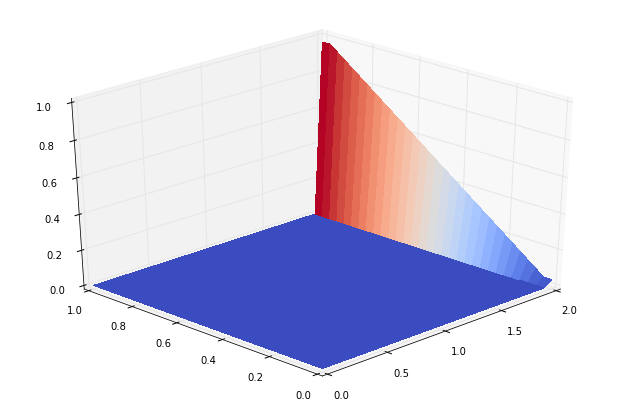

In [5]:
plot2D(x, y, p)

¡Ha funcionado! Este es el estado inicial de nuestro problema, donde el valor de `p` es cero en todas partes excepto por lo largo de $x=2$ donde $p=y$. Ahora vamos a tratar de ejecutar nuestra función `laplace2d` con L1 especificado de 0,01

(Sugerencia: si tienes problemas para recordar el orden en que se envían las variables a una función, puedes escribir `laplace2d(` y Notebook IPython mostrará un cuadro emergente para mostrártelo)

In [6]:
p = laplace2d(p, y, dx, dy, .01)

Ahora intenta representar este nuevo valor de `p` en nuestra función `plot2D`.

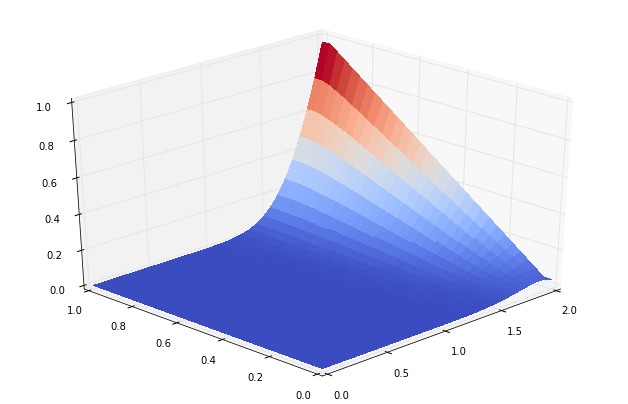

In [7]:
plot2D(x, y, p)

***

## Aprende más

En el [siguiente paso](http://nbviewer.ipython.org/urls/bitbucket.org/franktoffel/cfd-python-class-es/raw/master/lecciones/13%2520-%2520Paso%252010.ipynb) resolveremos la ecuación de Poisson. Mira la **Video Lesson 11** en YouTube para comprender por qué necesitamos la la ecuación de Poisson CFD.

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZjfxA3qq2Lg')

Y para un análsis detallado de la discretización de las ecuaciónes de Laplace y Poisson  (pasos 9 y 10), mira la **Video Lesson 12**:

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('iwL8ashXhWU')

In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

> (La celda de arriba establece el formato de este notebook)